# NetFlix Rating Prediction

For more information about the project structure and description see the github repository <b><a href="https://github.com/diegopmayer/netflix_rating_prediction">click here</a>

## 1.0 - Importing

### 1.1 - Libraries

In [520]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display  import HTML
from IPython.display       import Image

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import svm

from sklearn.linear_model import Lasso, LinearRegression
from sklearn.metrics import mean_absolute_error

### 1.2 - Helper Functions

In [498]:
def jupyter_settings():
    %matplotlib inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [18,9]
    plt.rcParams['font.size'] = 24
    
    display( HTML('<style>.container{width:90% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
jupyter_settings()  

def cramer_v(x, y):

    # cm is Confusion Matrix
    cm = pd.crosstab(x, y).values
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape
    
    return np.sqrt((chi2/n) / min(k-1, r-1))

def data_cleaning(data):

	# delete and replace all nullable values
	data = data[data['rating'].notnull()]
	data = data.dropna(how='all') # delet the line if all line null
	data['date_added'] = data['date_added'].fillna('1970-01-01')
	data['release_year'] = data['release_year'].fillna(0)
	data['rating'] = data['rating'].fillna(0)
	data['duration'].fillna(0)
	data = data.fillna('')
	
	
	# string cleaning
	# removing the string and left only minutes
	ind_season = data[data['duration'].str.contains('Season')].index
	data["duration"] = data["duration"].replace(" Season", "", regex=True)
	data["duration"] = data["duration"].replace(" min", "", regex=True)
	data["duration"] = data["duration"].replace("s", "", regex=True)
	data["duration"] = data["duration"].astype("int")
	# replace the TV show value for mode from movie
	data.loc[ind_season, 'duration'] = 51 # mean time of episodes
	
	# change dtype for simply, less memory and better performance
	data['date_added'] = pd.to_datetime(data['date_added'])
	data['release_year'] = data['release_year'].astype('int32')
	data['rating'] = data['rating'].astype('int32')
	df_cleaned = data
	
	return df_cleaned

	
def feature_eng(df_cleaned):
	df_cleaned['type'] = df_cleaned['type'].map({'Movie':0, 'TV Show':1})
	df_cleaned['year_added'] = df_cleaned['date_added'].dt.year
	df_cleaned['month_added'] = df_cleaned['date_added'].dt.month
	df_cleaned['day_added'] = df_cleaned['date_added'].dt.day

		# drop columns
	df_cleaned = df_cleaned.drop([
		'show_id',
		'title', 
		'director', 
		'cast', 
		'listed_in', 
		'description'
	], axis=1)
	
	# filter values
	df_cleaned = df_cleaned[df_cleaned['rating'] > 0]
	df_eng = df_cleaned.drop(['date_added'], axis=1)

	return df_eng


def data_transformation(df_eng):
	
	# duration
	rs = RobustScaler()
	df_eng['duration'] = rs.fit_transform(df_eng[['duration']].values)
	
	# country
	df_dum = pd.get_dummies(df_eng['country'])
	df_dum_red = pd.DataFrame()
	for col in df_dum:
		if df_dum[col].sum() > 5:
			df_dum_red[col] = df_dum[col]
	df_eng = pd.concat([df_eng, df_dum_red], axis=1)
	df_eng = df_eng.drop(['country'], axis=1)

	# renaming columns
	col_list = list()
	for col in df_eng.columns.to_list():
		col_list.append(col.replace(' ', '_').replace(',', ''))
	df_eng.columns = col_list

	df_transf = df_eng

	return df_transf

### 1.3 - Extracting Data

In [103]:
data = pd.read_excel("../dataset/bronze/dataset_netflix.xlsx")

In [104]:
#  Let' split the train and test because of data leakage
X_train, X_test, y_train, y_test = train_test_split(data, data["rating"], test_size=0.15)
X_train.drop(["rating"], axis=1,inplace=True)
X_test.drop(["rating"], axis=1,inplace=True)

# training and validation split
df_train = pd.concat([X_train, y_train], axis=1)
df_test = pd.concat([X_test, y_test], axis=1)

## 2.0 - Data Cleaning

In [105]:
# Dimension data
data.shape, df_train.shape, df_test.shape

((6234, 12), (5298, 12), (936, 12))

### 2.2 - Descriptive Statistical

In [6]:
# Numerical describe
num_data = (
    data.select_dtypes(
    include=['int64', 'int32', 'float64', 'float32']))
num_describe = (pd.concat([
    num_data.describe().T,
    pd.Series(num_data.kurtosis(), name='kurtosis'),
    pd.Series(num_data.skew(), name='skew')
    ], axis=1).round())
num_describe

# The Frequency is a peak and a little negative skew.

,count,mean,std,min,25%,50%,75%,max,kurtosis,skew
show_id,6234.0,76703679.0,10942965.0,247747.0,80035802.0,80163367.0,80244889.0,81235729.0,30.0,-5.0
release_year,6233.0,2013.0,9.0,1925.0,2013.0,2016.0,2018.0,2020.0,18.0,-4.0
rating,6233.0,64.0,19.0,0.0,59.0,68.0,76.0,97.0,4.0,-2.0


In [7]:
# Categorical
data.select_dtypes(
include=['object', 'string']).describe().T
# The top more watched was movie from the United States "before cleaning"

,count,unique,top,freq
type,6234,2,Movie,4265
title,6234,6172,The Silence,3
director,4264,3300,"Raúl Campos, Jan Suter",18
cast,6233,5470,bam,569
country,6233,555,United States,2031
duration,6233,201,1 Season,1321
listed_in,6233,461,Documentaries,299
description,6233,6225,A surly septuagenarian gets another chance at ...,3


In [8]:
# Date describe
data.describe(include=['datetime'], datetime_is_numeric=True).T

,count,mean,min,25%,50%,75%,max
date_added,6222,2018-07-01 17:22:37.377049088,2008-01-01,2017-10-01,2018-09-30,2019-06-08,2020-01-18


### 2.4 - Data Types and Nullable values

In [9]:
pd.concat([
    pd.Series(data.dtypes, name='dtypes'), 
    pd.Series(data.isna().sum(), name='null_values'), 
    data.head(3).T], 
    axis=1)
    # The target has one null value, this case I'll delete them and replace the others nullable values

,dtypes,null_values,0,1,2
show_id,int64,0,81145628,80117401,70234439
type,object,0,Movie,Movie,TV Show
title,object,0,Norm of the North: King Sized Adventure,Jandino: Whatever it Takes,Transformers Prime
director,object,1970,"Richard Finn, Tim Maltby",NaN,NaN
cast,object,1,"Alan Marriott, Andrew Toth, Brian Dobson, Cole...",Jandino Asporaat,"Peter Cullen, Sumalee Montano, Frank Welker, J..."
country,object,1,"United States, India, South Korea, China",United Kingdom,United States
date_added,datetime64[ns],12,2019-09-09 00:00:00,2016-09-09 00:00:00,2018-09-08 00:00:00
release_year,float64,1,2019.0,2016.0,2013.0
rating,float64,1,41.0,52.0,82.0
duration,object,1,90 min,94 min,1 Season


In [405]:
# Variables changes
def var_changes(data):
        
    # delete and replace all nullable values
    data = data[data['rating'].notnull()]
    data = data.dropna(how='all') # delet the line if all line null
    data['date_added'] = data['date_added'].fillna('1970-01-01')
    data['release_year'] = data['release_year'].fillna(0)
    data['rating'] = data['rating'].fillna(0)
    data = data.fillna('')

    # change dtype for simply, less memory and better performance
    data['date_added'] = pd.to_datetime(data['date_added'])
    data['release_year'] = data['release_year'].astype('int32')
    data['rating'] = data['rating'].astype('int32')
    return data

data = var_changes(data)
df_train = var_changes(df_train)
df_test = var_changes(df_test)


In [11]:
pd.concat([
    pd.Series(data.dtypes, name='dtypes'), 
    pd.Series(data.isna().sum(), name='null_values'), 
    data.head(3).T], 
    axis=1)
# all data null changed

,dtypes,null_values,0,1,2
show_id,int64,0,81145628,80117401,70234439
type,object,0,Movie,Movie,TV Show
title,object,0,Norm of the North: King Sized Adventure,Jandino: Whatever it Takes,Transformers Prime
director,object,0,"Richard Finn, Tim Maltby",,
cast,object,0,"Alan Marriott, Andrew Toth, Brian Dobson, Cole...",Jandino Asporaat,"Peter Cullen, Sumalee Montano, Frank Welker, J..."
country,object,0,"United States, India, South Korea, China",United Kingdom,United States
date_added,datetime64[ns],0,2019-09-09 00:00:00,2016-09-09 00:00:00,2018-09-08 00:00:00
release_year,int32,0,2019,2016,2013
rating,int32,0,41,52,82
duration,object,0,90 min,94 min,1 Season


### 2.6 - Save to silver layer

In [406]:
data.to_parquet("../dataset/silver/netflix.parquet")
df_train.to_parquet("../dataset/silver/netflix_train.parquet")
df_test.to_parquet("../dataset/silver/netflix_test.parquet")


## 4.0 - Exploratory Data Analysis

> The future engineering will be create with EDA will be doing

In [439]:
# extracting data from silver layer
dfcln = pd.read_parquet("../dataset/silver/netflix.parquet")
df_train = pd.read_parquet("../dataset/silver/netflix_train.parquet")
df_test = pd.read_parquet("../dataset/silver/netflix_test.parquet")

### 4.0 - Hypothesis 

> List the possible hypothesis or business statements

* The top movies are from The united states
* The top Tv Series are from The united states
* The top movies are about heroes
* The top movies are stories from books
* How more recently movie and from the United States it's better
* How more awards better the rating

> Will be answer on the next cycle

#### 4.1 Target

/home/diegopmayer/Documents/job_interview/eleflow/.venv/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


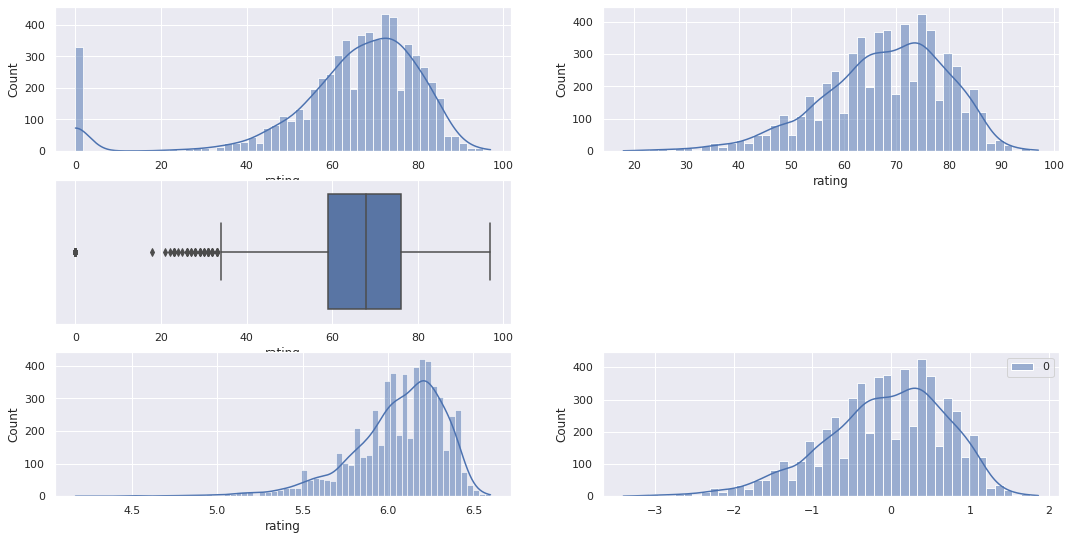

In [300]:
grid = plt.GridSpec(3,2)

# target distribution
subplot(grid[0,0])
sns.histplot(dfcln['rating'], kde=True);

# Target without zero values
subplot(grid[0,1])
sns.histplot(dfcln['rating'][dfcln['rating'] > 0], kde=True);

# Boxplot to see the outliers
subplot(grid[1,0])
sns.boxplot(x=dfcln['rating']);

# Analysing normalization
subplot(grid[2,0])
sns.histplot(np.log2(dfcln['rating']), kde=True)

# let's use the robust scaller because the outliers
subplot(grid[2,1])
scaler = RobustScaler()
sns.histplot(
    scaler.fit_transform(dfcln[dfcln['rating'] > 0][['rating']]
    .values), kde=True);

In [440]:
dfcln = dfcln[dfcln['rating'] > 0]

#### 4.2 Numeric

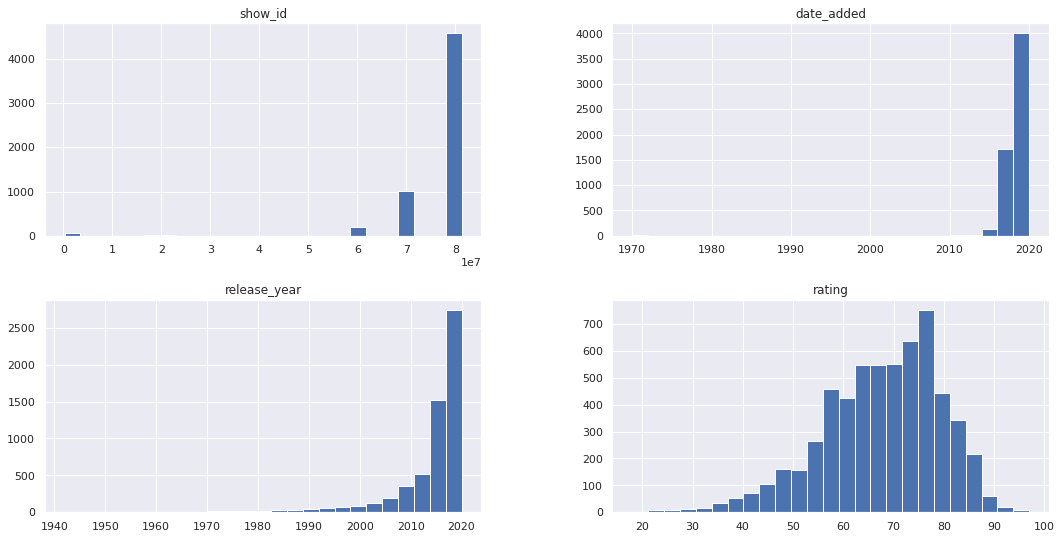

In [302]:
dfcln.select_dtypes(exclude=['object']).hist(bins=25);
# Let's drop col -> show_id

In [441]:
# Drop the show_id and rating = 0 (330 registers)
dfcln = dfcln.drop('show_id', axis=1)

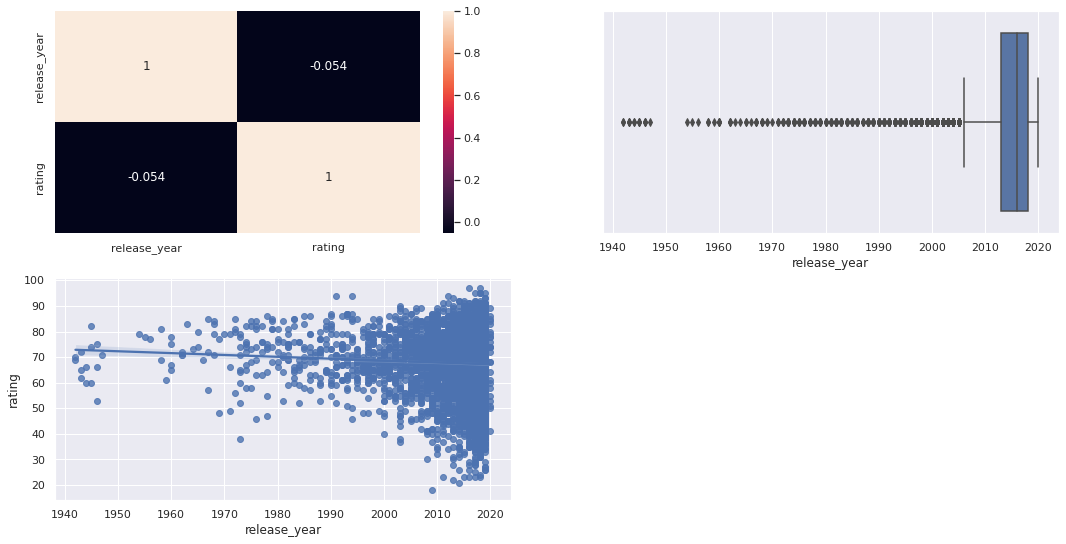

In [304]:
# Slicing and filter for just numbers and date data types
num_attributes = dfcln.select_dtypes(exclude='object')

grid = GridSpec(2,2)
# Plotting heatmap
subplot(grid[0,0])
sns.heatmap(num_attributes.corr(method='pearson'), annot=True);

subplot(grid[0,1])
sns.boxplot(x=dfcln['release_year']); 

subplot(grid[1,0])
sns.regplot(data=dfcln, x='release_year', y="rating");

# There are a consistently grouwing in a number of rating along years
# release_year there aren't a correlation with ratingj

In [442]:
dfcln['year_added'] = dfcln['date_added'].dt.year
dfcln['month_added'] = dfcln['date_added'].dt.month
dfcln['day_added'] = dfcln['date_added'].dt.day

# drop old column
dfcln = dfcln.drop(['date_added'], axis=1)

### 4.3 - Category

In [411]:
dfcln.head(3)

,type,title,director,cast,country,release_year,rating,duration,listed_in,description,year_added,month_added,day_added
0,Movie,Norm of the North: King Sized Adventure,"Richard Finn, Tim Maltby","Alan Marriott, Andrew Toth, Brian Dobson, Cole...","United States, India, South Korea, China",2019,41,90 min,"Children & Family Movies, Comedies",Before planning an awesome wedding for his gra...,2019,9,9
1,Movie,Jandino: Whatever it Takes,,Jandino Asporaat,United Kingdom,2016,52,94 min,Stand-Up Comedy,Jandino Asporaat riffs on the challenges of ra...,2016,9,9
2,TV Show,Transformers Prime,,"Peter Cullen, Sumalee Montano, Frank Welker, J...",United States,2013,82,1 Season,Kids' TV,"With the help of three human allies, the Autob...",2018,9,8


In [ ]:
# Slicing and filter for just objects data types
cat_attributes = dfcln.select_dtypes(include='object')

# For to get name of coluns and calculate cramer_v function 
list_cat = {}
rown = []
for col in cat_attributes.columns:
    for row in cat_attributes.columns:
        rown.append(cramer_v(cat_attributes[col], cat_attributes[row]))
        
    list_cat[col] = rown
    rown = []
    
# take the output from loop and convert to DataFrame
df_cat = pd.DataFrame(list_cat)
df_cat = df_cat.set_index(df_cat.columns)

Text(0.5, 1.0, 'Correlation of all categories variable')

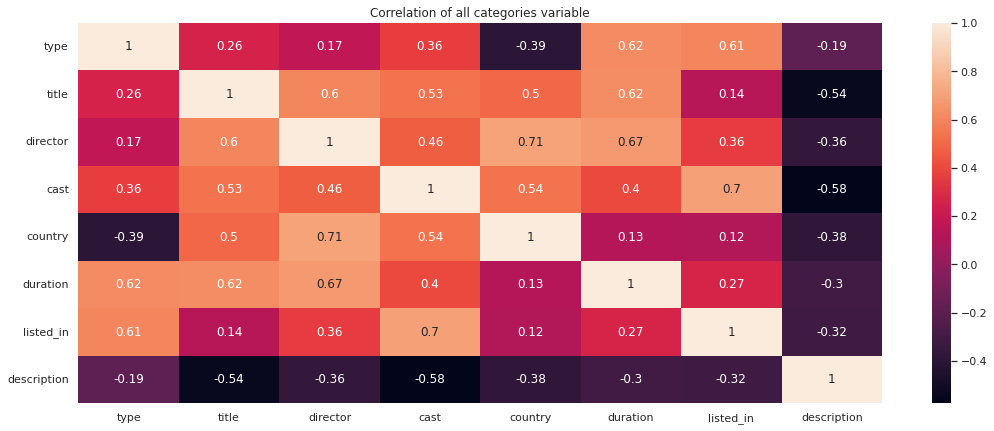

In [90]:
# plotting heatmap to cross correlation
sns.heatmap(df_cat.corr(method='pearson'), annot=True);
plt.title("Correlation of all categories variable")

# there aren't a strong correlation, but might be not need remove anyone
# Obs, Pearson it's not correct method for categories, just to first view

column type

Movie      4085
TV Show    1818
Name: type, dtype: int64


Text(0.5, 1.0, 'Correlation for rating and type')

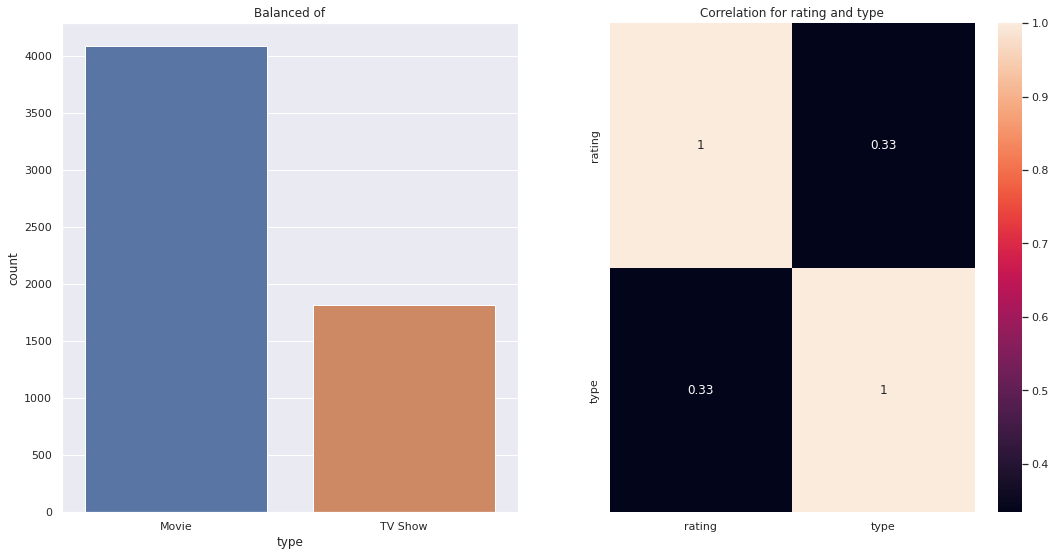

In [309]:
print(dfcln['type'].value_counts())
# type - transform to numeric
type_num = dfcln['type'].map({'Movie':0, 'TV Show':1})

grid = GridSpec(1,2)

subplot(grid[0,0])
sns.countplot(x=dfcln['type']);
plt.title("Balanced of")

subplot(grid[0,1])
sns.heatmap(
    pd.concat([dfcln['rating'], type_num], axis=1)
    .corr(method='pearson'), annot=True);
plt.title("Correlation for rating and type")


In [443]:
# engoding the type
dfcln['type'] = dfcln['type'].map({'Movie':0, 'TV Show':1})

column duration

In [413]:
# duration column
dfcln['duration'].head()

0      90 min
1      94 min
2    1 Season
3    1 Season
4      99 min
Name: duration, dtype: object

In [444]:
# removing the string and left only minutes
ind_season = dfcln[dfcln['duration'].str.contains('Season')].index
dfcln["duration"] = dfcln["duration"].replace(" Season", "", regex=True)
dfcln["duration"] = dfcln["duration"].replace(" min", "", regex=True)
dfcln["duration"] = dfcln["duration"].replace("s", "", regex=True)
dfcln["duration"] = dfcln["duration"].astype("int")
# replace the TV show value for mode from movie
dfcln.loc[ind_season, 'duration'] = int(dfcln[dfcln['type'] == 0]['duration'].mode())

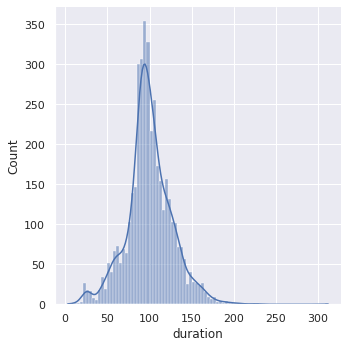

In [313]:
sns.displot(x=dfcln['duration'], kde=True);

In [337]:
rb = RobustScaler()
dfcln['duration'] = rb.fit_transform(dfcln[['duration']].values)

country

(547,)


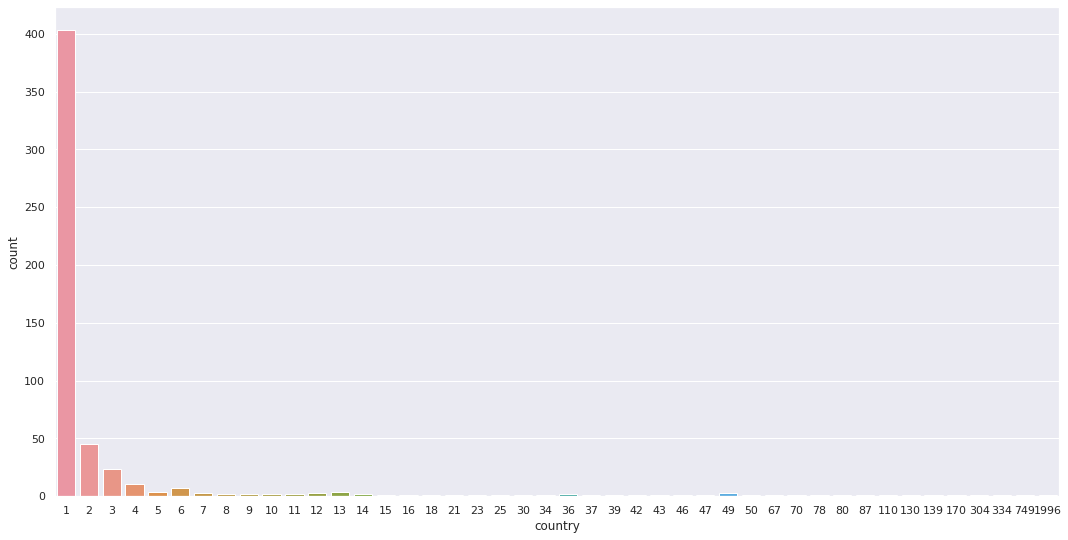

In [316]:
print(dfcln['country'].value_counts().shape)
sns.countplot(x=dfcln['country'].value_counts());
# for the first cycle I will just crate dummies with frequency > 5
# next cycle, it'll be cleaned and dimentionality reduction

In [338]:
df_dum = pd.get_dummies(dfcln['country'])
df_dum_red = pd.DataFrame()
for col in df_dum:
    if df_dum[col].sum() > 5:
        df_dum_red[col] = df_dum[col]

dfcln = pd.concat([dfcln, df_dum_red], axis=1)

# removing old columns
dfcln = dfcln.drop(['country'], axis=1)

texts columns

In [341]:
print(dfcln['title'].value_counts().shape)
print(dfcln['director'].value_counts().shape)
print(dfcln['cast'].value_counts().shape)
print(dfcln['listed_in'].value_counts().shape)
print(dfcln['description'].value_counts().shape)
# There are a lot of differents, and it's necessary do a text analysis
# I left this for the next cycle


(5841,)
(3205,)
(5236,)
(455,)
(5902,)


In [342]:
dfcln = dfcln.drop([
    'title', 
    'director', 
    'cast', 
    'listed_in', 
    'description'
    ], axis=1)

In [495]:
col_list = list()
for col in df_train.columns.to_list():
    col_list.append(col.replace(' ', '_').replace(',', ''))

df_train.columns = col_list

## 6.0 - Modeling 

In [499]:
# ETL from Function created
# Data for train
df_train = pd.read_parquet("../dataset/silver/netflix_train.parquet")
df_train = data_cleaning(df_train)
df_train = feature_eng(df_train)
df_train = data_transformation(df_train)

x_train = df_train.drop(["rating"], axis=1)
y_train = df_train['rating']

In [500]:
# Data for test
df_test = pd.read_parquet("../dataset/silver/netflix_test.parquet")
df_test = data_cleaning(df_test)
df_test = feature_eng(df_test)
df_test = data_transformation(df_test)

x_test = df_test.drop(['rating'], axis=1)
y_test = df_test['rating']

In [513]:
(df_train.shape, x_train.shape, y_train.shape,
    df_test.shape, x_test.shape, y_test.shape)

# I had a problem with train and test, because there are different
# dimentionality, for this cycle, I'll split together.

((5020, 62), (5020, 61), (5020,), (883, 25), (883, 24), (883,))

In [516]:
data = pd.read_excel("../dataset/bronze/dataset_netflix.xlsx")
data = data_cleaning(data)
data = feature_eng(data)
data = data_transformation(data)

x_train, x_test, y_train, y_test = train_test_split(
    data.drop(['rating'], axis=1), data['rating'], test_size=20, random_state=42)

### 6.1 - Baseline

### 6.2 - Models

In [521]:
models = {
    'Lasso': linear_model.Lasso(random_state=1),
    'SVM': svm.SVR(),
    'Linear Regression':linear_model.LinearRegression(),
    'Random Forest Regressor': RandomForestRegressor(random_state=1),
}

In [523]:
results = {}
for im in models:
    model = models[im]
    model = model.fit(x_train, y_train)
    predictions = model.predict(x_test)
    results[im] = round(mean_absolute_error(y_test, predictions),2)

In [524]:
pd.DataFrame(results.items(), columns=['Model', 'MAE']).sort_values(by="MAE")

,Model,MAE
0,Lasso,9.38
2,Linear Regression,9.59
1,SVM,10.30
3,Random Forest Regressor,10.64


### 6.3 - Cross Validation

### 6.4 - Hyperparameters Fine Tuning

### 6.5 - Final Model

### 6.6 - Business Performance

## 7.0 - Patterns for production

In [469]:
def data_cleaning(data):

	# delete and replace all nullable values
	data = data[data['rating'].notnull()]
	data = data.dropna(how='all') # delet the line if all line null
	data['date_added'] = data['date_added'].fillna('1970-01-01')
	data['release_year'] = data['release_year'].fillna(0)
	data['rating'] = data['rating'].fillna(0)
	data['duration'].fillna(0)
	data = data.fillna('')
	
	
	# string cleaning
	# removing the string and left only minutes
	ind_season = data[data['duration'].str.contains('Season')].index
	data["duration"] = data["duration"].replace(" Season", "", regex=True)
	data["duration"] = data["duration"].replace(" min", "", regex=True)
	data["duration"] = data["duration"].replace("s", "", regex=True)
	data["duration"] = data["duration"].astype("int")
	# replace the TV show value for mode from movie
	data.loc[ind_season, 'duration'] = 51 # mean time of episodes
	
	# change dtype for simply, less memory and better performance
	data['date_added'] = pd.to_datetime(data['date_added'])
	data['release_year'] = data['release_year'].astype('int32')
	data['rating'] = data['rating'].astype('int32')
	df_cleaned = data
	
	return df_cleaned

	
def feature_eng(df_cleaned):
	df_cleaned['type'] = df_cleaned['type'].map({'Movie':0, 'TV Show':1})
	df_cleaned['year_added'] = df_cleaned['date_added'].dt.year
	df_cleaned['month_added'] = df_cleaned['date_added'].dt.month
	df_cleaned['day_added'] = df_cleaned['date_added'].dt.day

		# drop columns
	df_cleaned = df_cleaned.drop([
		'show_id',
		'title', 
		'director', 
		'cast', 
		'listed_in', 
		'description'
	], axis=1)
	
	# filter values
	df_cleaned = df_cleaned[df_cleaned['rating'] > 0]
	df_eng = df_cleaned.drop(['date_added'], axis=1)

	return df_eng


def data_transformation(df_eng):
	
	# duration
	rs = RobustScaler()
	df_eng['duration'] = rs.fit_transform(df_eng[['duration']].values)
	
	# country
	df_dum = pd.get_dummies(df_eng['country'])
	df_dum_red = pd.DataFrame()
	for col in df_dum:
		if df_dum[col].sum() > 5:
			df_dum_red[col] = df_dum[col]
	df_eng = pd.concat([df_eng, df_dum_red], axis=1)
	df_eng = df_eng.drop(['country'], axis=1)

	# renaming columns
	col_list = list()
	for col in df_eng.columns.to_list():
		col_list.append(col.replace(' ', '_').replace(',', ''))
	df_eng.columns = col_list

	df_transf = df_eng
	
	return df_transf

## 8.0 - Next steps to improve the solution

* Create a solution to analyse the text "sentiment analysis" or others.
* better feature engineering with more calculus.
* Cross Validation and fine tunning.
* Identify the principal actor on all cast column
* Collect the data for imdb rating
* Collect the data for design production and effects
* Collect the data for the company that film the movie production
* Collect the data for user (click, views, watched, etc)